In [0]:
!pip uninstall opencv-python -y
!pip install opencv-python==3.4.2.16 --force-reinstall
!pip install opencv-contrib-python==3.4.2.16 --force-reinstall

In [0]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import imutils

Saving s1.jpg to s1.jpg


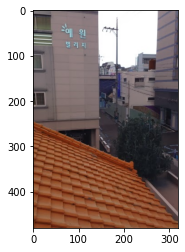

In [97]:
from google.colab import files
uploaded = files.upload()
training_image=cv2.imread('s1.jpg')
plt.imshow(training_image)

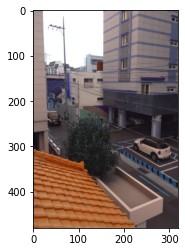

In [99]:
uploaded = files.upload()
test_image=cv2.imread('s2.jpg')
plt.imshow(test_image)

In [0]:
class Panaroma:

    def image_stitch(self, images, lowe_ratio=0.75, max_Threshold=4.0,match_status=False):

        #detect the features and keypoints from SIFT
        (imageB, imageA) = images
        (KeypointsA, features_of_A) = self.Detect_Feature_And_KeyPoints(imageA)
        (KeypointsB, features_of_B) = self.Detect_Feature_And_KeyPoints(imageB)

        #got the valid matched points
        Values = self.matchKeypoints(KeypointsA, KeypointsB,features_of_A, features_of_B, lowe_ratio, max_Threshold)

        if Values is None:
            return None

        #to get perspective of image using computed homography
        (matches, Homography, status) = Values
        result_image = self.getwarp_perspective(imageA,imageB,Homography)
        result_image[0:imageB.shape[0], 0:imageB.shape[1]] = imageB

        # check to see if the keypoint matches should be visualized
        if match_status:
            vis = self.draw_Matches(imageA, imageB, KeypointsA, KeypointsB, matches,status)

            return (result_image, vis)

        return result_image

    def getwarp_perspective(self,imageA,imageB,Homography):
        val = imageA.shape[1] + imageB.shape[1]
        result_image = cv2.warpPerspective(imageA, Homography, (val , imageA.shape[0]))

        return result_image

    def Detect_Feature_And_KeyPoints(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # detect and extract features from the image
        descriptors = cv2.xfeatures2d.SIFT_create()
        (Keypoints, features) = descriptors.detectAndCompute(image, None)

        Keypoints = np.float32([i.pt for i in Keypoints])
        return (Keypoints, features)

    def get_Allpossible_Match(self,featuresA,featuresB):

        # compute the all matches using euclidean distance and opencv provide
        #DescriptorMatcher_create() function for that
        match_instance = cv2.DescriptorMatcher_create("BruteForce")
        All_Matches = match_instance.knnMatch(featuresA, featuresB, 2)

        return All_Matches

    def All_validmatches(self,AllMatches,lowe_ratio):
        #to get all valid matches according to lowe concept..
        valid_matches = []

        for val in AllMatches:
            if len(val) == 2 and val[0].distance < val[1].distance * lowe_ratio:
                valid_matches.append((val[0].trainIdx, val[0].queryIdx))

        return valid_matches

    def Compute_Homography(self,pointsA,pointsB,max_Threshold):
        #to compute homography using points in both images

        (H, status) = cv2.findHomography(pointsA, pointsB, cv2.RANSAC, max_Threshold)
        return (H,status)

    def matchKeypoints(self, KeypointsA, KeypointsB, featuresA, featuresB,lowe_ratio, max_Threshold):

        AllMatches = self.get_Allpossible_Match(featuresA,featuresB);
        valid_matches = self.All_validmatches(AllMatches,lowe_ratio)

        if len(valid_matches) > 4:
            # construct the two sets of points
            pointsA = np.float32([KeypointsA[i] for (_,i) in valid_matches])
            pointsB = np.float32([KeypointsB[i] for (i,_) in valid_matches])

            (Homograpgy, status) = self.Compute_Homography(pointsA, pointsB, max_Threshold)

            return (valid_matches, Homograpgy, status)
        else:
            return None

    def get_image_dimension(self,image):
        (h,w) = image.shape[:2]
        return (h,w)

    def get_points(self,imageA,imageB):

        (hA, wA) = self.get_image_dimension(imageA)
        (hB, wB) = self.get_image_dimension(imageB)
        vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
        vis[0:hA, 0:wA] = imageA
        vis[0:hB, wA:] = imageB

        return vis


    def draw_Matches(self, imageA, imageB, KeypointsA, KeypointsB, matches, status):

        (hA,wA) = self.get_image_dimension(imageA)
        vis = self.get_points(imageA,imageB)

        # loop over the matches
        for ((trainIdx, queryIdx), s) in zip(matches, status):
            if s == 1:
                ptA = (int(KeypointsA[queryIdx][0]), int(KeypointsA[queryIdx][1]))
                ptB = (int(KeypointsB[trainIdx][0]) + wA, int(KeypointsB[trainIdx][1]))
                cv2.line(vis, ptA, ptB, (0, 255, 0), 1)

        return vis

In [0]:
panaroma = Panaroma()
result, matched_points = panaroma.image_stitch([training_image, test_image], match_status=True)

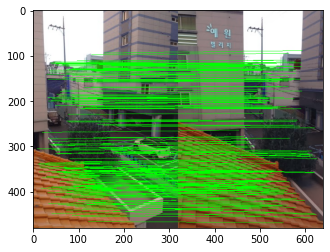

In [103]:
plt.imshow(matched_points)

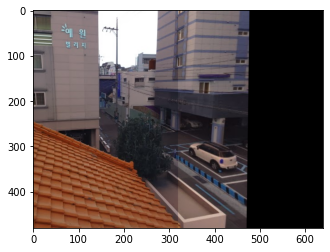

In [104]:
plt.imshow(result)